In [56]:
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from numpy import pi
import operator

In [75]:
checkpoint_file="checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp = pickle.load(cp_file)

In [76]:
def get_ind_list(pop_list, index):
    ind_list = [] 
    for pop in pop_list:
        ind_list.append(pop[index])
    return ind_list


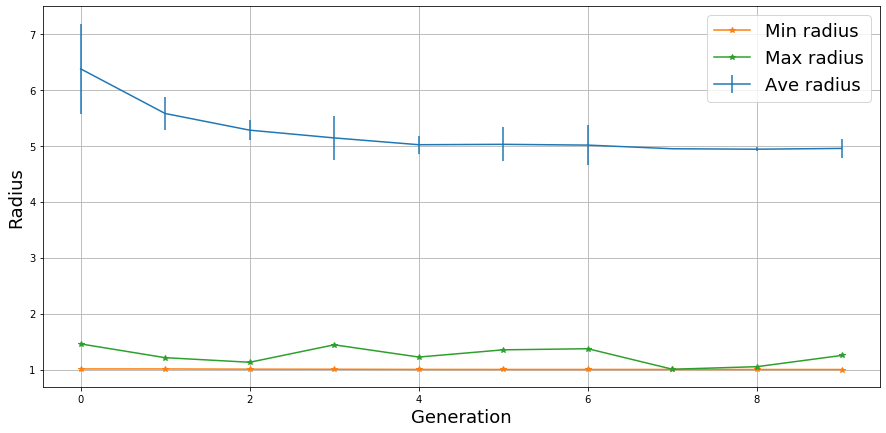

In [84]:
# Radius plot
logbook = cp["logbook"]
gen = logbook.select("gen")
rad_avg = get_ind_list(logbook.chapters["oup"].select("avg"), 0)
rad_std = get_ind_list(logbook.chapters["oup"].select("std"), 0)
rad_min = get_ind_list(logbook.chapters["oup"].select("min"), 0)
rad_max = get_ind_list(logbook.chapters["oup"].select("max"), 0)
fig, ax = plt.subplots(figsize=(15,7))
ax.errorbar(gen, rad_avg, yerr=rad_std, label="Ave radius")
ax.plot(gen, keff_min, "*-", label="Min radius")
ax.plot(gen, keff_max, "*-", label="Max radius")
ax.set_xlabel("Generation", fontsize=18)
ax.set_ylabel("Radius", fontsize=18)
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18)
fig.savefig('radius-convergence.png',bbox_inches='tight', dpi=300)